# 2D indentation using Argiope & Hardness



In [115]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [390]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import hardness as hd
import argiope as ag
import pandas as pd
import numpy as np
import os, subprocess, time, local_settings, time
%matplotlib nbagg

mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['contour.negative_linestyle'] = 'solid'

# USEFUL FUNCTIONS
def create_dir(path):
  try:
    os.mkdir(path)
  except:
    pass

## Settings

In [505]:
# SETTINGS
workdir   = "workdir/"
outputdir = "outputs/"
label   = "indentation_2D"

create_dir(workdir)
create_dir(workdir + outputdir)     

## Model definition

In [516]:
#-------------------------------------------------------------------------------
# MESH DEFINITIONS
def element_map(mesh):
    mesh.elements.loc[mesh.elements.type.argiope == "tri3", ("type", "solver", "")] = "CAX3" 
    mesh.elements.loc[mesh.elements.type.argiope == "quad4", ("type", "solver", "")] = "CAX4R" 
    return mesh
    
    
def sample_material_map(mesh):
    mesh.elements["materials"] = "SAMPLE_MAT" 
    return mesh

def indenter_material_map(mesh):
    mesh.elements["materials"] = "INDENTER_MAT" 
    return mesh
    
    
meshes = {
    "sample" : hd.models.Sample2D(lx = 1., ly = 1., 
                                   r1 = 2., r2 = 3., 
                                   Nx = 64, Ny = 32,
                                   Nr = 2, Nt = 64, 
                                   gmsh_path = "gmsh",
                                   file_name = "dummy", 
                                   workdir = workdir, 
                                   gmsh_space = 2, 
                                   gmsh_options = "-algo 'delquad'",
                                   element_map = element_map,
                                   material_map = sample_material_map),
                                   
    "indenter" : hd.models.SpheroconicalIndenter2D(
                                   R = 1.,
                                   psi= 30., 
                                   r1 = 1., 
                                   r2 = 3., 
                                   r3 = 3., 
                                   lc1 = .03, 
                                   lc2 = .5,
                                   rigid = False,
                                   gmsh_path = "gmsh",
                                   file_name = "dummy", 
                                   workdir = workdir, 
                                   gmsh_space = 2, 
                                   gmsh_options = "-algo 'delquad'",
                                   element_map = element_map,
                                   material_map = indenter_material_map)}
                                   
materials = [ag.materials.Hollomon(label = "SAMPLE_MAT", strain_data_points = 100),
             ag.materials.Hollomon(label = "INDENTER_MAT", strain_data_points = 100)]

#-------------------------------------------------------------------------------
# STEP DEFINTIONS
steps = [
        hd.models.Step2D(name = "LOADING1",
                         control_type = "disp", 
                         duration = 1.,
                         kind = "adaptative",  
                         nframes = 50,
                         controlled_value = -0.2,
                         field_output_frequency = 99999),
        hd.models.Step2D(name = "UNLOADING1",
                         control_type = "force", 
                         duration = 1.,
                         kind = "adaptative",  
                         nframes = 50,
                         controlled_value = 0.,
                         field_output_frequency = 99999),
        hd.models.Step2D(name = "RELOADING1",
                         control_type = "disp", 
                         duration = 1.,
                         kind = "adaptative",  
                         nframes = 50,
                         controlled_value = -0.2,
                         field_output_frequency = 99999),
        hd.models.Step2D(name = "LOADING2",
                         control_type = "disp", 
                         duration = 1.,
                         kind = "adaptative",  
                         nframes = 50,
                         controlled_value = -0.4,
                         field_output_frequency = 99999),                                    
        hd.models.Step2D(name = "UNLOADING2",
                         control_type = "force",
                         kind = "adaptative", 
                         duration = 1., 
                         nframes = 50,
                         controlled_value = 0.,
                         field_output_frequency = 99999)
        ]                                                                                                  

model0 = hd.models.Indentation2D(label = label, 
                      meshes = meshes, 
                      steps = steps, 
                      materials = materials, 
                      solver = "abaqus", 
                      solver_path = local_settings.ABAQUS_PATH,
                      workdir = workdir,
                      verbose = True)



In [517]:
model0.write_input()
#model0.run_simulation()
model0.postproc()
model0.save(workdir + "model.pcklz")
del model0

<Running "indentation_2D" using abaqus>
(b'Abaqus JOB indentation_2D\nAbaqus 6.13-1\nBegin Analysis Input File Processor\nTue Apr 11 16:08:01 2017\nRun pre\nTue Apr 11 16:08:06 2017\nEnd Analysis Input File Processor\nBegin Abaqus/Standard Analysis\nTue Apr 11 16:08:06 2017\nRun standard\nTue Apr 11 16:12:08 2017\nEnd Abaqus/Standard Analysis\nAbaqus JOB indentation_2D COMPLETED\n', None)
<Ran indentation_2D: duration 252.65s>
<Post-Processing"indentation_2D" using abaqus>
<Post-Processed indentation_2D: duration 9.53s>


In [518]:
model = ag.utils.load(workdir + "model.pcklz")

## Model checking

Mesh building and quality checking.

In [519]:
meshes["indenter"].mesh.elements.head()

type        conn                        sets     materials  \
        argiope solver   n0   n1   n2   n3 ALL_ELEMENTS                 
                                                                        
element                                                                 
99         tri3   CAX3  128   40   41    0         True  INDENTER_MAT   
100        tri3   CAX3   41   42  128    0         True  INDENTER_MAT   
101       quad4  CAX4R  780  810  800  771         True  INDENTER_MAT   
102       quad4  CAX4R  856  835  811  847         True  INDENTER_MAT   
103       quad4  CAX4R  699  668  596  628         True  INDENTER_MAT   

        surfaces                       
         SURFACE                       
              f1     f2     f3     f4  
element                                
99         False   True  False  False  
100         True  False  False  False  
101        False  False  False  False  
102        False  False  False  False  
103        False  False  False  False

In [520]:
meshes["sample"].mesh.elements.head()

type        conn                  sets                materials  \
        argiope solver   n0   n1   n2   n3 SHELL2 SHELL1  CORE               
                                                                             
element                                                                      
225       quad4  CAX4R    1    9  385  196  False  False  True  SAMPLE_MAT   
226       quad4  CAX4R  196  385  386  195  False  False  True  SAMPLE_MAT   
227       quad4  CAX4R  195  386  387  194  False  False  True  SAMPLE_MAT   
228       quad4  CAX4R  194  387  388  193  False  False  True  SAMPLE_MAT   
229       quad4  CAX4R  193  388  389  192  False  False  True  SAMPLE_MAT   

                sets surfaces                      
        ALL_ELEMENTS  SURFACE                      
                           f1     f2     f3    f4  
element                                            
225             True    False  False  False  True  
226             True    False  False  False  True  
227             True    False  False  False  True  
228             True    False  False  False  True  
229             True    False  False  False  True

<IPython.core.display.Javascript object>


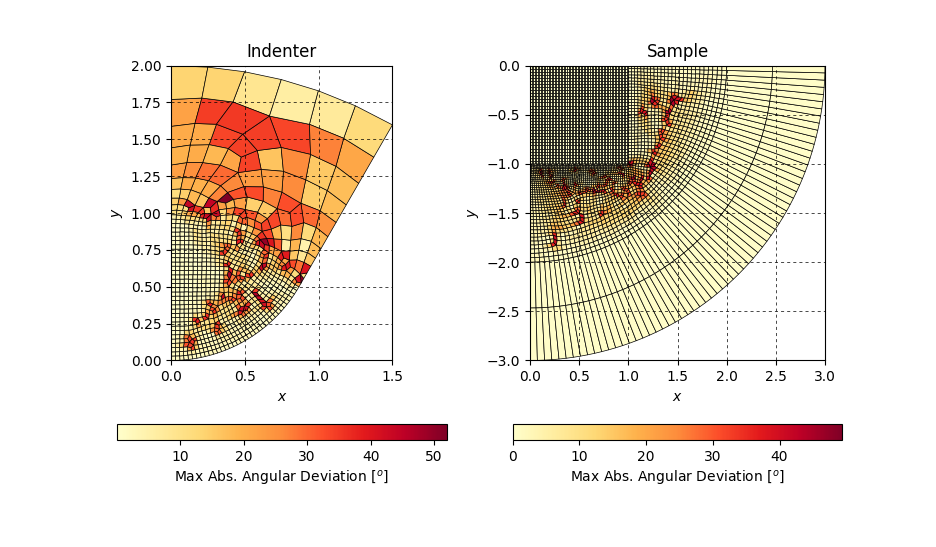

/home/lcharleux/Documents/Informatique/anaconda/lib/python3.5/site-packages/ipykernel/zmqshell.py:501: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


In [521]:
i = 1
fig = plt.figure()
parts_names = meshes.keys()
for name, part in meshes.items(): 
    mesh = part.mesh
    patches = mesh.to_polycollection(edgecolor = "black", linewidth = .5, alpha = 1.)
    stats = mesh.stats()
    patches.set_array( stats.stats.max_abs_angular_deviation )
    patches.set_cmap(mpl.cm.YlOrRd)
    ax = fig.add_subplot(1, 2, i)
    ax.set_aspect("equal")
    ax.set_xlim(mesh.nodes.coords.x.min(), mesh.nodes.coords.x.max())
    ax.set_ylim(mesh.nodes.coords.y.min(), mesh.nodes.coords.y.max())
    ax.add_collection(patches)
    cbar = plt.colorbar(patches, orientation = "horizontal")
    cbar.set_label("Max Abs. Angular Deviation [$^o$]")
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.grid()
    plt.title(name.title())
    i+= 1
plt.show()


## Simulation

## Post-Processing

### Time data


In [523]:
hist = model.data["history"]
hist.head()

,Wes,Wf,RF,Wtot,dtot,dtip,Wei,CF,Wps,t,step,F
0,0.000000e+00,0.0,-0.000000,0.000000e+00,0.000,0.000000,0.000000e+00,0.0,0.000000e+00,0.00,0,0.000000
1,1.330767e-07,0.0,-0.000181,4.512419e-07,-0.004,-0.001947,1.352046e-07,0.0,2.516743e-09,0.02,0,-0.000181
2,6.791204e-07,0.0,-0.000497,1.879632e-06,-0.008,-0.003739,6.929380e-07,0.0,9.194124e-08,0.04,0,-0.000497
3,1.678691e-06,0.0,-0.000876,4.686754e-06,-0.012,-0.005771,1.714267e-06,0.0,4.229573e-07,0.06,0,-0.000876
4,3.154047e-06,0.0,-0.001318,9.151297e-06,-0.016,-0.007493,3.252141e-06,0.0,1.061309e-06,0.08,0,-0.001318


<IPython.core.display.Javascript object>


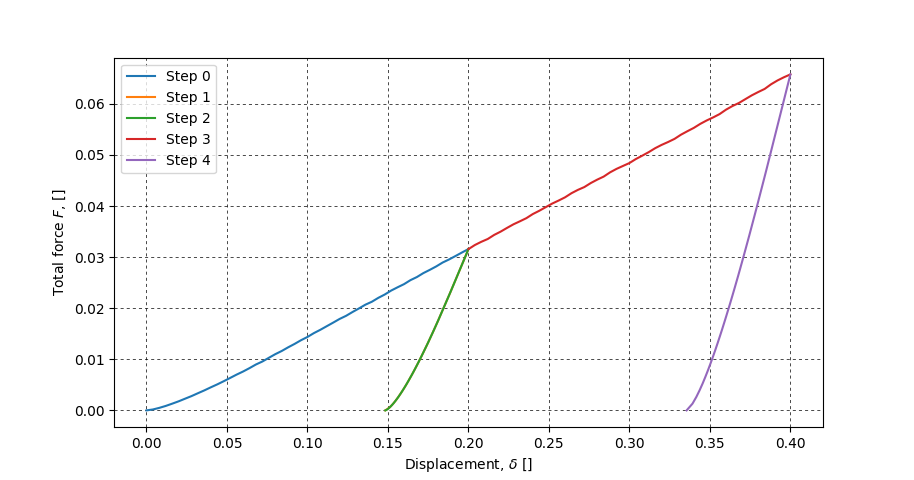

In [524]:
plt.figure()
for step, group in hist.groupby("step"):
  plt.plot(-group.dtot, -group.F, label = "Step {0}".format(step))
plt.grid()
plt.legend(loc = "best")
plt.ylabel("Total force $F$, []")
plt.xlabel("Displacement, $\delta$ []")
plt.show()

### Fields

In [525]:
model.meshes["sample"].mesh.fields_metadata()

,frame,frame_value,label,part,position,step_label,step_num
0,0,0,S,I_SAMPLE,node,LOADING1,0
1,0,0,U,I_SAMPLE,node,LOADING1,0
2,1,1,S,I_SAMPLE,node,LOADING1,0
3,1,1,U,I_SAMPLE,node,LOADING1,0
4,0,0,S,I_SAMPLE,node,UNLOADING1,1
5,0,0,U,I_SAMPLE,node,UNLOADING1,1
6,1,1,S,I_SAMPLE,node,UNLOADING1,1
7,1,1,U,I_SAMPLE,node,UNLOADING1,1
8,0,0,S,I_SAMPLE,node,RELOADING1,2
9,0,0,U,I_SAMPLE,node,RELOADING1,2


In [526]:
model.meshes["sample"].mesh.fields_metadata()

,frame,frame_value,label,part,position,step_label,step_num
0,0,0,S,I_SAMPLE,node,LOADING1,0
1,0,0,U,I_SAMPLE,node,LOADING1,0
2,1,1,S,I_SAMPLE,node,LOADING1,0
3,1,1,U,I_SAMPLE,node,LOADING1,0
4,0,0,S,I_SAMPLE,node,UNLOADING1,1
5,0,0,U,I_SAMPLE,node,UNLOADING1,1
6,1,1,S,I_SAMPLE,node,UNLOADING1,1
7,1,1,U,I_SAMPLE,node,UNLOADING1,1
8,0,0,S,I_SAMPLE,node,RELOADING1,2
9,0,0,U,I_SAMPLE,node,RELOADING1,2


<IPython.core.display.Javascript object>


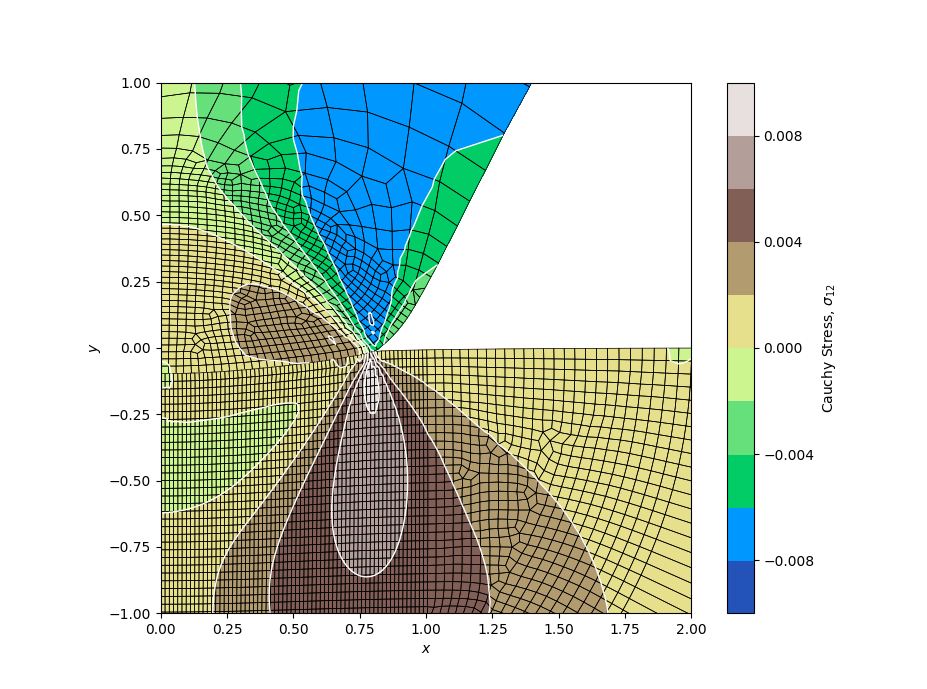

In [527]:
meshes = {k:part.mesh.copy() for k, part in model.meshes.items() }

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_aspect("equal")
ax.set_xlim(0., 2.)
ax.set_ylim(-1., 1.)

field_num = 14 
disp_num = 15
levels = np.linspace(-1.e-2, 1.e-2, 11)

for k, mesh in meshes.items():
    field = mesh.fields[field_num].data.v12
    disp = mesh.fields[disp_num].data
    mesh.nodes[("coords", "x")] += disp.v1
    mesh.nodes[("coords", "y")] += disp.v2
    tri = mesh.to_triangulation()
    patches = mesh.to_polycollection(facecolor = "none",
                                     edgecolor = "black",
                                     linewidth = .5) 
    grad = ax.tricontourf(tri, field, levels, cmap = mpl.cm.terrain, alpha = 1)
    ax.tricontour(tri, field, levels, colors = "white", linewidths = 1.)
    ax.add_collection(patches)
cbar = plt.colorbar(grad)
cbar.set_label("Cauchy Stress, $\sigma_{12}$")
plt.xlabel("$x$")
plt.ylabel("$y$")
#plt.grid()